# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)

class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
import time

In [7]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    start_time = time.time()
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, dim=1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("[%d/%d]" % (epoch + 1, num_epochs), end=' ')
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    
    time_elapsed = time.time() - start_time
    print("Time elapsed: %f sec." % time_elapsed)
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    
    correct_samples = 0
    total_samples = 0
    for x, y in loader:
        prediction = model(x)
        indices = torch.argmax(prediction, dim=1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples
    
    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

[1/3] Average loss: 1.821626, Train accuracy: 0.416050, Val accuracy: 0.552112
[2/3] Average loss: 1.448819, Train accuracy: 0.588967, Val accuracy: 0.602348
[3/3] Average loss: 1.376096, Train accuracy: 0.621046, Val accuracy: 0.611835
Time elapsed: 43.714363 sec.


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [8]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

[1/5] Average loss: 2.183791, Train accuracy: 0.199553, Val accuracy: 0.232134
[2/5] Average loss: 2.022408, Train accuracy: 0.264853, Val accuracy: 0.308716
[3/5] Average loss: 1.819924, Train accuracy: 0.370440, Val accuracy: 0.406593
[4/5] Average loss: 1.713342, Train accuracy: 0.417995, Val accuracy: 0.432598
[5/5] Average loss: 1.682313, Train accuracy: 0.432737, Val accuracy: 0.439424
Time elapsed: 73.058512 sec.


Добавьте слой с Batch Normalization

In [9]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

[1/5] Average loss: 2.072519, Train accuracy: 0.295311, Val accuracy: 0.425022
[2/5] Average loss: 1.777025, Train accuracy: 0.475941, Val accuracy: 0.532796
[3/5] Average loss: 1.634326, Train accuracy: 0.545814, Val accuracy: 0.580779
[4/5] Average loss: 1.544696, Train accuracy: 0.585060, Val accuracy: 0.602962
[5/5] Average loss: 1.481089, Train accuracy: 0.608368, Val accuracy: 0.633950
Time elapsed: 79.672784 sec.


Добавьте уменьшение скорости обучения по ходу тренировки.

In [10]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    start_time = time.time()
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, dim=1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        scheduler.step()
        
        print("[%d/%d]" % (epoch + 1, num_epochs), end=' ')
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    
    time_elapsed = time.time() - start_time
    print("Time elapsed: %f sec." % time_elapsed)
    return loss_history, train_history, val_history

In [11]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 5)

[1/5] Average loss: 2.094733, Train accuracy: 0.297376, Val accuracy: 0.429049
[2/5] Average loss: 1.785233, Train accuracy: 0.482152, Val accuracy: 0.537779
[3/5] Average loss: 1.653931, Train accuracy: 0.543187, Val accuracy: 0.559416
[4/5] Average loss: 1.596352, Train accuracy: 0.568884, Val accuracy: 0.580302
[5/5] Average loss: 1.553831, Train accuracy: 0.587073, Val accuracy: 0.592656
Time elapsed: 79.124010 sec.


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [12]:
# class SubsetSampler(Sampler):
#     r"""Samples elements with given indices sequentially

#     Arguments:
#         indices (ndarray): indices of the samples to take
#     """

#     def __init__(self, indices):
#         self.indices = indices

#     def __iter__(self):
#         return (self.indices[i] for i in range(len(self.indices)))

#     def __len__(self):
#         return len(self.indices)

In [13]:
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval()
    
    loader = torch.utils.data.DataLoader(dataset, sampler=indices)
    predictions = np.zeros(len(indices), dtype=int)
    ground_truth = np.zeros(len(indices), dtype=int)
    
    for i_step, (x, y) in enumerate(loader):
        pred = torch.argmax(model(x), dim=1)
        ground_truth[i_step] = y
        predictions[i_step] = pred
    return predictions, ground_truth

predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

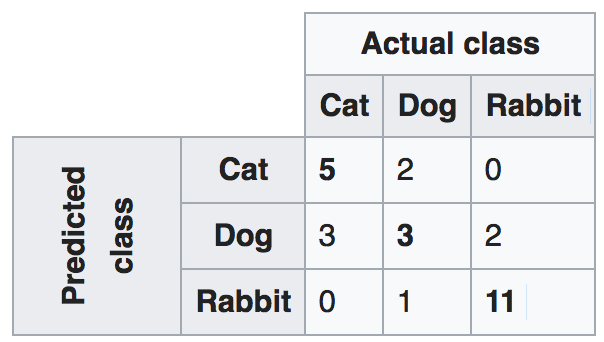

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

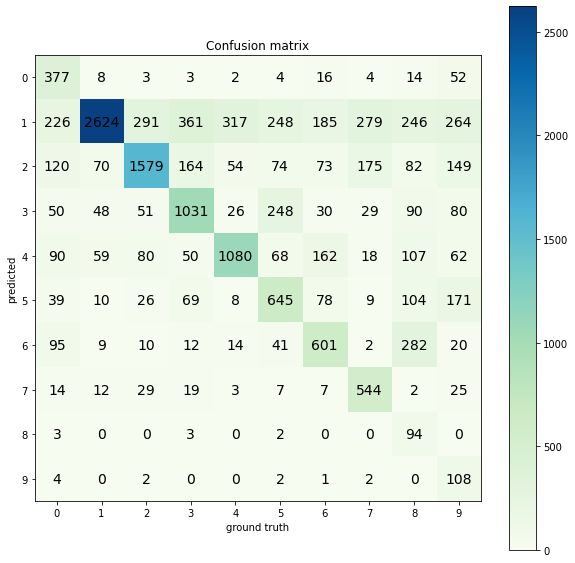

In [14]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10, 10), dtype=int)
    
    for pred in range(10):
        for gt in range(10):
            confusion_matrix[pred][gt] = np.sum((ground_truth == gt) & (predictions == pred))

    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

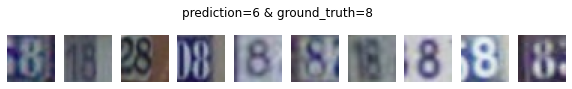

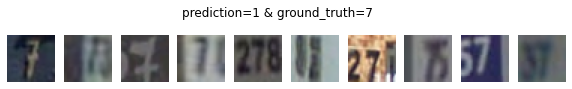

In [15]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    indices = val_indices[(predictions == predicted_class) & (groud_truth == gt_class)]
    visualize_images(indices, data, 'prediction=' + str(predicted_class) + ' & ground_truth=' + str(gt_class))

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [16]:
import random

In [17]:
scheduler_step_size = 2
scheduler_gamma = 0.95
num_epochs = 5
batch_size = 64
hidden_in = 100
hidden_out = 100

best_val_accuracy = None
best_learning_rate = None
best_weight_decay = None
best_loss_history = None
best_train_history = None
best_val_history = None

num_steps = 10

for i in range(1, num_steps + 1):
    learning_rate = 10 ** random.uniform(-6, -2)
    weight_decay = 10 ** random.uniform(-5, -1)
        
    print('Step [%d/%d]' % (i, num_steps))
    print('LearningRate = %f\nWeightDecay = %f' % (learning_rate, weight_decay))
        
    nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, hidden_in),
                nn.BatchNorm1d(hidden_in),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_in, hidden_out),
                nn.BatchNorm1d(hidden_out),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_out, 10), 
                )

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                           loss, optimizer, scheduler, num_epochs=num_epochs)
        
    val_accuracy = val_history[-1]
        
    if best_val_accuracy is None or best_val_accuracy < val_accuracy:
        best_val_accuracy = val_accuracy
        best_learning_rate = learning_rate
        best_weight_decay = weight_decay
        best_loss_history = loss_history
        best_train_history = train_history
        best_val_history = val_history
    print()

print('Best results for (LearningRate, WeightDecay):')
print('LearningRate = %f\nWeightDecay = %f\n=> ValidationAccuracy = %f' % (best_learning_rate, 
                                                                          best_weight_decay, 
                                                                          best_val_accuracy))

Step [1/10]
LearningRate = 0.005900
WeightDecay = 0.000969
[1/5] Average loss: 1.504586, Train accuracy: 0.492049, Val accuracy: 0.628012
[2/5] Average loss: 1.207224, Train accuracy: 0.615637, Val accuracy: 0.627397
[3/5] Average loss: 1.121140, Train accuracy: 0.648244, Val accuracy: 0.665415
[4/5] Average loss: 1.081967, Train accuracy: 0.662338, Val accuracy: 0.679612
[5/5] Average loss: 1.048811, Train accuracy: 0.673890, Val accuracy: 0.665825
Time elapsed: 158.186293 sec.

Step [2/10]
LearningRate = 0.000818
WeightDecay = 0.074858
[1/5] Average loss: 1.724005, Train accuracy: 0.427345, Val accuracy: 0.471367
[2/5] Average loss: 1.685112, Train accuracy: 0.464696, Val accuracy: 0.464746
[3/5] Average loss: 1.784907, Train accuracy: 0.425503, Val accuracy: 0.429595
[4/5] Average loss: 1.802630, Train accuracy: 0.416510, Val accuracy: 0.408505
[5/5] Average loss: 1.810850, Train accuracy: 0.411903, Val accuracy: 0.418333
Time elapsed: 85.291617 sec.

Step [3/10]
LearningRate = 0.00

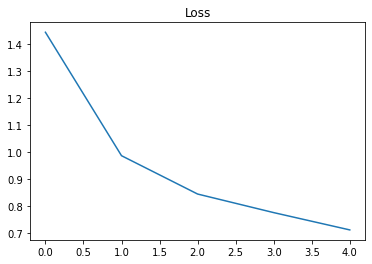

In [18]:
plt.title("Loss")
plt.plot(best_loss_history)
plt.show()

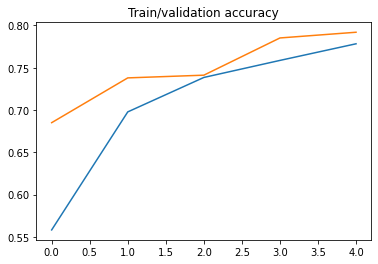

In [19]:
plt.title("Train/validation accuracy")
plt.plot(best_train_history)
plt.plot(best_val_history)
plt.show()

In [20]:
scheduler_step_size = 2
scheduler_gamma = 0.95
num_epochs = 5
batch_size = 64
hidden_in = 100
hidden_out = 100

best_val_accuracy = None
best_learning_rate = None
best_weight_decay = None
best_loss_history = None
best_train_history = None
best_val_history = None

learning_rates = [1e-4, 2e-4, 3e-4]
weight_decays = [1e-4, 5e-5, 2e-5]

counter = 0
num_steps = len(learning_rates) * len(weight_decays)
for learning_rate in learning_rates:
    for weight_decay in weight_decays:
        counter += 1
        print('Step [%d/%d]' % (counter, num_steps))
        print('LearningRate = %f\nWeightDecay = %f' % (learning_rate, weight_decay))
        
        nn_model = nn.Sequential(
                    Flattener(),
                    nn.Linear(3*32*32, hidden_in),
                    nn.BatchNorm1d(hidden_in),
                    nn.ReLU(inplace=True),
                    nn.Linear(hidden_in, hidden_out),
                    nn.BatchNorm1d(hidden_out),
                    nn.ReLU(inplace=True),
                    nn.Linear(hidden_out, 10), 
                 )

        train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
        val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

        optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
        loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                               loss, optimizer, scheduler, num_epochs=num_epochs)
        
        val_accuracy = val_history[-1]
        
        if best_val_accuracy is None or best_val_accuracy < val_accuracy:
            best_val_accuracy = val_accuracy
            best_learning_rate = learning_rate
            best_weight_decay = weight_decay
            best_loss_history = loss_history
            best_train_history = train_history
            best_val_history = val_history
        print()

print('Best results for (LearningRate, WeightDecay):')
print('LearningRate = %f\nWeightDecay = %f\n=> ValidationAccuracy = %f' % (best_learning_rate, 
                                                                          best_weight_decay, 
                                                                          best_val_accuracy))

Step [1/9]
LearningRate = 0.000100
WeightDecay = 0.000200
[1/5] Average loss: 1.606105, Train accuracy: 0.522216, Val accuracy: 0.662207
[2/5] Average loss: 1.095099, Train accuracy: 0.681381, Val accuracy: 0.704662
[3/5] Average loss: 0.911480, Train accuracy: 0.725932, Val accuracy: 0.749096
[4/5] Average loss: 0.817119, Train accuracy: 0.751800, Val accuracy: 0.774623
[5/5] Average loss: 0.751549, Train accuracy: 0.769478, Val accuracy: 0.786704
Time elapsed: 84.146011 sec.

Step [2/9]
LearningRate = 0.000100
WeightDecay = 0.000100
[1/5] Average loss: 1.591175, Train accuracy: 0.518496, Val accuracy: 0.666371
[2/5] Average loss: 1.094992, Train accuracy: 0.685135, Val accuracy: 0.726367
[3/5] Average loss: 0.924780, Train accuracy: 0.724499, Val accuracy: 0.741997
[4/5] Average loss: 0.830880, Train accuracy: 0.749121, Val accuracy: 0.761108
[5/5] Average loss: 0.757253, Train accuracy: 0.769529, Val accuracy: 0.786090
Time elapsed: 87.010403 sec.

Step [3/9]
LearningRate = 0.000100

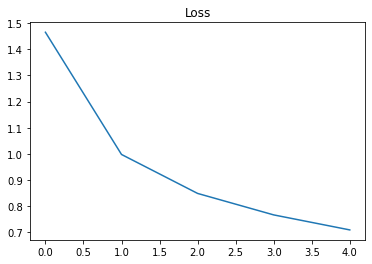

In [21]:
plt.title("Loss")
plt.plot(best_loss_history)
plt.show()

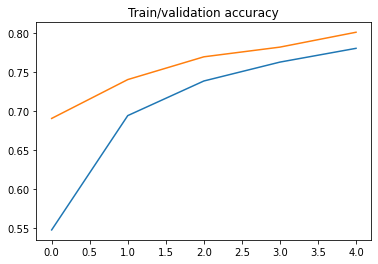

In [22]:
plt.title("Train/validation accuracy")
plt.plot(best_train_history)
plt.plot(best_val_history)
plt.show()

In [23]:
learning_rate = best_learning_rate
weight_decay = best_weight_decay

scheduler_step_size = 2
scheduler_gamma = 0.95
num_epochs = 5
hidden_in = 100
hidden_out = 100

best_val_accuracy = None
best_batch_size = None
best_loss_history = None
best_train_history = None
best_val_history = None

num_steps = 8
batch_sizes = [2 ** i for i in range(3, num_steps + 3)]

counter = 0
for batch_size in batch_sizes:
    counter += 1
    print('Step [%d/%d]' % (counter, num_steps))
    print('BatchSize = %d' % batch_size)
        
    nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, hidden_in),
                nn.BatchNorm1d(hidden_in),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_in, hidden_out),
                nn.BatchNorm1d(hidden_out),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_out, 10), 
                )

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                           loss, optimizer, scheduler, num_epochs=num_epochs)
        
    val_accuracy = val_history[-1]
        
    if best_val_accuracy is None or best_val_accuracy < val_accuracy:
        best_val_accuracy = val_accuracy
        best_batch_size = batch_size
        best_loss_history = loss_history
        best_train_history = train_history
        best_val_history = val_history
    print()

print('Best results for BatchSize:')
print('BatchSize = %d\n=> ValidationAccuracy = %f' % (best_batch_size, best_val_accuracy))

Step [1/8]
BatchSize = 8
[1/5] Average loss: 1.725087, Train accuracy: 0.424922, Val accuracy: 0.641594
[2/5] Average loss: 1.382393, Train accuracy: 0.555813, Val accuracy: 0.688622
[3/5] Average loss: 1.265377, Train accuracy: 0.597550, Val accuracy: 0.718722
[4/5] Average loss: 1.204085, Train accuracy: 0.618111, Val accuracy: 0.735513
[5/5] Average loss: 1.151212, Train accuracy: 0.634645, Val accuracy: 0.742475
Time elapsed: 245.179184 sec.

Step [2/8]
BatchSize = 16
[1/5] Average loss: 1.540328, Train accuracy: 0.501041, Val accuracy: 0.670739
[2/5] Average loss: 1.160199, Train accuracy: 0.631113, Val accuracy: 0.707733
[3/5] Average loss: 1.033702, Train accuracy: 0.673463, Val accuracy: 0.752645
[4/5] Average loss: 0.963788, Train accuracy: 0.696465, Val accuracy: 0.778445
[5/5] Average loss: 0.913847, Train accuracy: 0.711292, Val accuracy: 0.779128
Time elapsed: 153.173432 sec.

Step [3/8]
BatchSize = 32
[1/5] Average loss: 1.456226, Train accuracy: 0.542504, Val accuracy: 0

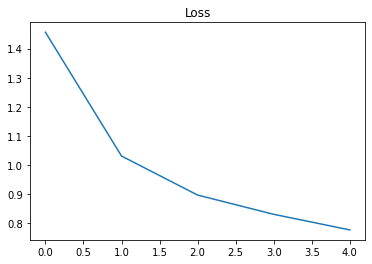

In [24]:
plt.title("Loss")
plt.plot(best_loss_history)
plt.show()

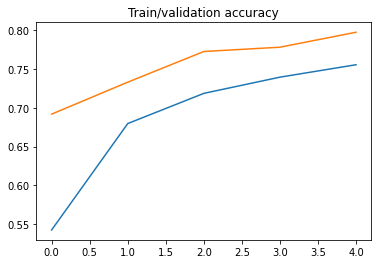

In [25]:
plt.title("Train/validation accuracy")
plt.plot(best_train_history)
plt.plot(best_val_history)
plt.show()

In [26]:
learning_rate = best_learning_rate
weight_decay = best_weight_decay
batch_size = best_batch_size

scheduler_step_size = 2
scheduler_gamma = 0.95
num_epochs = 5

best_val_accuracy = None
best_hidden_in = None
best_hidden_out = None
best_loss_history = None
best_train_history = None
best_val_history = None

num_steps = 4
hidden_in_list = [50 * i for i in range(1, num_steps + 1)]
hidden_out_list = [50 * i for i in range(1, num_steps + 1)]

counter = 0
for hidden_in in hidden_in_list:
    for hidden_out in hidden_out_list:
        counter += 1
        print('Step [%d/%d]' % (counter, num_steps * num_steps))
        print('HiddenIn = %d' % hidden_in)
        print('HiddenOut = %d' % hidden_out)

        nn_model = nn.Sequential(
                    Flattener(),
                    nn.Linear(3*32*32, hidden_in),
                    nn.BatchNorm1d(hidden_in),
                    nn.ReLU(inplace=True),
                    nn.Linear(hidden_in, hidden_out),
                    nn.BatchNorm1d(hidden_out),
                    nn.ReLU(inplace=True),
                    nn.Linear(hidden_out, 10), 
                    )
        
        train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
        val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

        optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
        loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                               loss, optimizer, scheduler, num_epochs=num_epochs)

        val_accuracy = val_history[-1]

        if best_val_accuracy is None or best_val_accuracy < val_accuracy:
            best_val_accuracy = val_accuracy
            best_hidden_in = hidden_in
            best_hidden_out = hidden_out
            best_loss_history = loss_history
            best_train_history = train_history
            best_val_history = val_history
        print()

print('Best results for (HiddenIn, HiddenOut):')
print('HiddenIn = %d' % best_hidden_in)
print('HiddenOut = %d' % best_hidden_out)
print('=> ValidationAccuracy = %f' % best_val_accuracy)

Step [1/16]
HiddenIn = 50
HiddenOut = 50
[1/5] Average loss: 1.576579, Train accuracy: 0.502952, Val accuracy: 0.649922
[2/5] Average loss: 1.146792, Train accuracy: 0.643978, Val accuracy: 0.692717
[3/5] Average loss: 1.006674, Train accuracy: 0.686568, Val accuracy: 0.731554
[4/5] Average loss: 0.941542, Train accuracy: 0.705423, Val accuracy: 0.760699
[5/5] Average loss: 0.888735, Train accuracy: 0.723305, Val accuracy: 0.759812
Time elapsed: 87.524386 sec.

Step [2/16]
HiddenIn = 50
HiddenOut = 100
[1/5] Average loss: 1.521129, Train accuracy: 0.520663, Val accuracy: 0.658590
[2/5] Average loss: 1.093215, Train accuracy: 0.659369, Val accuracy: 0.704116
[3/5] Average loss: 0.971382, Train accuracy: 0.696806, Val accuracy: 0.743567
[4/5] Average loss: 0.902023, Train accuracy: 0.716940, Val accuracy: 0.747594
[5/5] Average loss: 0.852090, Train accuracy: 0.734106, Val accuracy: 0.774077
Time elapsed: 89.950717 sec.

Step [3/16]
HiddenIn = 50
HiddenOut = 150
[1/5] Average loss: 1.504

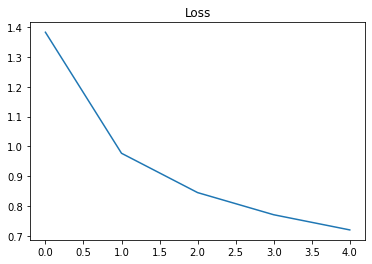

In [27]:
plt.title("Loss")
plt.plot(best_loss_history)
plt.show()

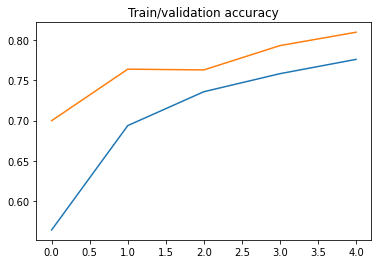

In [28]:
plt.title("Train/validation accuracy")
plt.plot(best_train_history)
plt.plot(best_val_history)
plt.show()

# Посмотрим, как модель работает на тестовых данных

In [29]:
learning_rate = best_learning_rate
weight_decay = best_weight_decay
batch_size = best_batch_size
hidden_in = best_hidden_in
hidden_out = best_hidden_out
scheduler_step_size = 2
scheduler_gamma = 0.95
num_epochs = 100

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, hidden_in),
            nn.BatchNorm1d(hidden_in),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_in, hidden_out),
            nn.BatchNorm1d(hidden_out),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_out, 10), 
            )
        
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                               loss, optimizer, scheduler, num_epochs=num_epochs)

[1/100] Average loss: 1.387510, Train accuracy: 0.564413, Val accuracy: 0.705344
[2/100] Average loss: 0.976754, Train accuracy: 0.695321, Val accuracy: 0.728483
[3/100] Average loss: 0.836806, Train accuracy: 0.737979, Val accuracy: 0.778036
[4/100] Average loss: 0.768732, Train accuracy: 0.759479, Val accuracy: 0.791550
[5/100] Average loss: 0.711056, Train accuracy: 0.776576, Val accuracy: 0.805065
[6/100] Average loss: 0.680250, Train accuracy: 0.784954, Val accuracy: 0.807385
[7/100] Average loss: 0.648622, Train accuracy: 0.797239, Val accuracy: 0.822128
[8/100] Average loss: 0.625713, Train accuracy: 0.803638, Val accuracy: 0.825131
[9/100] Average loss: 0.609749, Train accuracy: 0.808637, Val accuracy: 0.832571
[10/100] Average loss: 0.586008, Train accuracy: 0.816299, Val accuracy: 0.837485
[11/100] Average loss: 0.566666, Train accuracy: 0.821366, Val accuracy: 0.835779
[12/100] Average loss: 0.554053, Train accuracy: 0.825513, Val accuracy: 0.838373
[13/100] Average loss: 0.

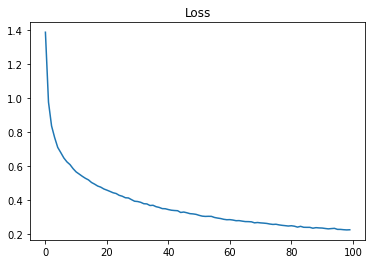

In [33]:
plt.title("Loss")
plt.plot(loss_history)
plt.show()

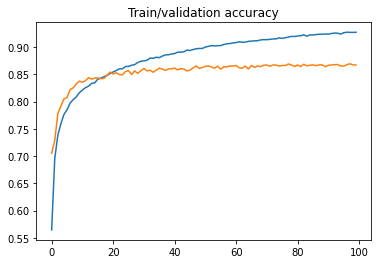

In [34]:
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)
plt.show()

In [35]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8443


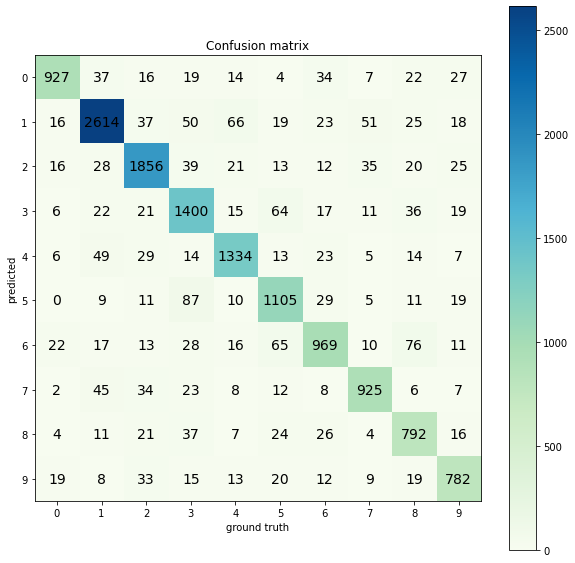

In [41]:
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

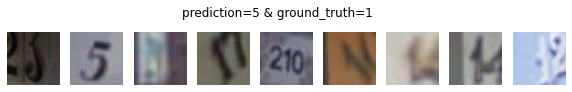

In [42]:
visualize_predicted_actual(5, 1, predictions, gt, np.array(val_indices), data_train_images)